In [1]:
from reactor_ode_test import states
import matplotlib.pyplot as plt


Running Cantera version: 2.4.0a1


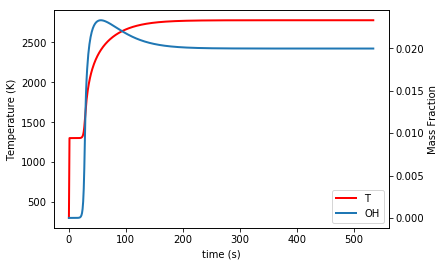

In [2]:
L1 = plt.plot(states.T, color='r', label='T', lw=2)
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')
plt.twinx()
# L2 = plt.plot(states.t, states('OH').Y, label='OH', lw=2)
L2 = plt.plot(states('OH').Y, label='OH', lw=2)
plt.ylabel('Mass Fraction')
plt.legend(L1 + L2, [line.get_label() for line in L1 + L2], loc='lower right')


plt.show()

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

import os

os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K

K.set_floatx('float32')
print(K.floatx())

from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization, Activation, Dropout
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from res_block import res_block

Using TensorFlow backend.


float32


In [4]:
from reactor_ode import train_org, train_new, train_res
#from sklearn.utils import shuffle

# prepare data
# train_org = train_org[0.000:0.001]
# train_new = train_new[0.000:0.001]
# train_org, train_new = shuffle(train_org, train_new)

output = train_org.columns
label_values = []
input_norm_scalers = {}
input_std_scalers = {}
for itm in output:
    print(itm)
    norm_scaler = MinMaxScaler()
    std_scaler = StandardScaler()
    # same input_label scaler
    # std_scaler.fit(np.concatenate([train_org[itm], train_new[itm]], axis=0).reshape(-1, 1))
    # out = std_scaler.transform(train_org[itm].values.reshape(-1, 1))
    # input scaler
    out = std_scaler.fit_transform(train_org[itm].values.reshape(-1, 1))
    # out = out/out.max()
    out = 2 * norm_scaler.fit_transform(out) - 1

    label_values.append(out)
    input_norm_scalers[itm] = norm_scaler
    input_std_scalers[itm] = std_scaler

x_train = np.concatenate(
    label_values,
    axis=1)

output = train_new.columns
# output = ['H2']
label_values = []
label_norm_scalers = {}
label_std_scalers = {}
for itm in output:
    print(itm)
    # same input_label scaler
    # out = input_std_scalers[itm].transform(train_new[itm].values.reshape(-1, 1))
    # input scaler
    norm_scaler = MinMaxScaler()
    std_scaler = StandardScaler()
    # out = train_new[itm].values.reshape(-1, 1)
    out = std_scaler.fit_transform(train_new[itm].values.reshape(-1, 1))
    # out = out-out.min()
    out = 2 * norm_scaler.fit_transform(out) - 1

    label_values.append(out)
    label_norm_scalers[itm] = norm_scaler
    label_std_scalers[itm] = std_scaler

y_train = np.concatenate(
    label_values,
    axis=1
)

Running Cantera version: 2.4.0a1
H2
H
O2
OH
O
H2O
HO2
H2O2
N2
temperature
H2
H
O2
OH
O
H2O
HO2
H2O2
N2
temperature


In [5]:
######################
print('set up ANN')
# ANN parameters
dim_input = x_train.shape[1]
dim_label = y_train.shape[1]
n_neuron = 100
batch_size = 512
epochs = 500
vsplit = 0.1
batch_norm = True

# This returns a tensor
inputs = Input(shape=(dim_input,), dtype='float32')
print(inputs.dtype)
# a layer instance is callable on a tensor, and returns a tensor
x = Dense(n_neuron, name='1_base')(inputs)
# x = BatchNormalization(axis=-1, name='1_base_bn')(x)
x = Activation('relu')(x)

# less then 2 res_block, there will be variance
x = res_block(x, n_neuron, stage=1, block='a', bn=batch_norm)
x = res_block(x, n_neuron, stage=1, block='b', bn=batch_norm)

# x = res_block(x, n_neuron, stage=1, block='c', bn=batch_norm)
# x = res_block(x, n_neuron, stage=1, block='d', bn=batch_norm)

predictions = Dense(dim_label, activation='linear')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

# checkpoint (save the best model based validate loss)
filepath = "./tmp/weights.best.cntk.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=10)
callbacks_list = [checkpoint]

# fit the model
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
    callbacks=callbacks_list,
    shuffle=True)

model.load_weights("./tmp/weights.best.cntk.hdf5")

set up ANN
<dtype: 'float32'>
Train on 8987 samples, validate on 999 samples
Epoch 1/500
1s - loss: 0.7125 - acc: 0.2899 - val_loss: 0.6375 - val_acc: 0.0030
Epoch 2/500
0s - loss: 0.2963 - acc: 0.6316 - val_loss: 0.4746 - val_acc: 0.5315
Epoch 3/500
0s - loss: 0.2083 - acc: 0.7249 - val_loss: 0.4171 - val_acc: 0.5315
Epoch 4/500
0s - loss: 0.1714 - acc: 0.7821 - val_loss: 0.3688 - val_acc: 0.5315
Epoch 5/500
0s - loss: 0.1439 - acc: 0.8081 - val_loss: 0.3206 - val_acc: 0.4194
Epoch 6/500
0s - loss: 0.1258 - acc: 0.8069 - val_loss: 0.2801 - val_acc: 0.4194
Epoch 7/500
0s - loss: 0.1168 - acc: 0.8295 - val_loss: 0.2731 - val_acc: 0.4194
Epoch 8/500
0s - loss: 0.1081 - acc: 0.8385 - val_loss: 0.2495 - val_acc: 0.4224
Epoch 9/500
0s - loss: 0.0957 - acc: 0.8395 - val_loss: 0.2317 - val_acc: 0.4244
Epoch 10/500
Epoch 00009: val_loss improved from inf to 0.20402, saving model to ./tmp/weights.best.cntk.hdf5
0s - loss: 0.0941 - acc: 0.8429 - val_loss: 0.2040 - val_acc: 0.4304
Epoch 11/500
0s

0s - loss: 0.0174 - acc: 0.9337 - val_loss: 0.0501 - val_acc: 0.6587
Epoch 93/500
0s - loss: 0.0169 - acc: 0.9309 - val_loss: 0.0475 - val_acc: 0.6557
Epoch 94/500
0s - loss: 0.0161 - acc: 0.9301 - val_loss: 0.0452 - val_acc: 0.6486
Epoch 95/500
0s - loss: 0.0174 - acc: 0.9289 - val_loss: 0.0543 - val_acc: 0.6557
Epoch 96/500
0s - loss: 0.0177 - acc: 0.9283 - val_loss: 0.0542 - val_acc: 0.6597
Epoch 97/500
0s - loss: 0.0172 - acc: 0.9330 - val_loss: 0.0538 - val_acc: 0.6587
Epoch 98/500
0s - loss: 0.0162 - acc: 0.9369 - val_loss: 0.0540 - val_acc: 0.6577
Epoch 99/500
0s - loss: 0.0165 - acc: 0.9351 - val_loss: 0.0492 - val_acc: 0.6527
Epoch 100/500
Epoch 00099: val_loss did not improve
0s - loss: 0.0161 - acc: 0.9331 - val_loss: 0.0503 - val_acc: 0.6647
Epoch 101/500
0s - loss: 0.0173 - acc: 0.9261 - val_loss: 0.0445 - val_acc: 0.6557
Epoch 102/500
0s - loss: 0.0161 - acc: 0.9281 - val_loss: 0.0445 - val_acc: 0.6627
Epoch 103/500
0s - loss: 0.0160 - acc: 0.9345 - val_loss: 0.0458 - val

0s - loss: 0.0094 - acc: 0.9430 - val_loss: 0.0869 - val_acc: 0.6587
Epoch 189/500
0s - loss: 0.0094 - acc: 0.9396 - val_loss: 0.0854 - val_acc: 0.6406
Epoch 190/500
Epoch 00189: val_loss did not improve
0s - loss: 0.0099 - acc: 0.9399 - val_loss: 0.0802 - val_acc: 0.6587
Epoch 191/500
0s - loss: 0.0102 - acc: 0.9355 - val_loss: 0.0815 - val_acc: 0.6567
Epoch 192/500
0s - loss: 0.0092 - acc: 0.9359 - val_loss: 0.0794 - val_acc: 0.6537
Epoch 193/500
0s - loss: 0.0092 - acc: 0.9408 - val_loss: 0.0824 - val_acc: 0.6567
Epoch 194/500
0s - loss: 0.0097 - acc: 0.9381 - val_loss: 0.0848 - val_acc: 0.6587
Epoch 195/500
0s - loss: 0.0105 - acc: 0.9370 - val_loss: 0.0837 - val_acc: 0.6637
Epoch 196/500
0s - loss: 0.0096 - acc: 0.9379 - val_loss: 0.0856 - val_acc: 0.6657
Epoch 197/500
0s - loss: 0.0083 - acc: 0.9430 - val_loss: 0.0833 - val_acc: 0.6587
Epoch 198/500
0s - loss: 0.0097 - acc: 0.9349 - val_loss: 0.0897 - val_acc: 0.6547
Epoch 199/500
0s - loss: 0.0095 - acc: 0.9381 - val_loss: 0.093

0s - loss: 0.0074 - acc: 0.9464 - val_loss: 0.1023 - val_acc: 0.6877
Epoch 285/500
0s - loss: 0.0079 - acc: 0.9425 - val_loss: 0.0976 - val_acc: 0.6857
Epoch 286/500
0s - loss: 0.0087 - acc: 0.9382 - val_loss: 0.1035 - val_acc: 0.6777
Epoch 287/500
0s - loss: 0.0079 - acc: 0.9433 - val_loss: 0.1001 - val_acc: 0.6727
Epoch 288/500
0s - loss: 0.0079 - acc: 0.9369 - val_loss: 0.1017 - val_acc: 0.6847
Epoch 289/500
0s - loss: 0.0072 - acc: 0.9466 - val_loss: 0.1021 - val_acc: 0.6747
Epoch 290/500
Epoch 00289: val_loss did not improve
0s - loss: 0.0070 - acc: 0.9451 - val_loss: 0.1022 - val_acc: 0.6827
Epoch 291/500
0s - loss: 0.0068 - acc: 0.9445 - val_loss: 0.1094 - val_acc: 0.6787
Epoch 292/500
0s - loss: 0.0073 - acc: 0.9420 - val_loss: 0.0998 - val_acc: 0.6787
Epoch 293/500
0s - loss: 0.0075 - acc: 0.9420 - val_loss: 0.1063 - val_acc: 0.6817
Epoch 294/500
0s - loss: 0.0072 - acc: 0.9407 - val_loss: 0.1091 - val_acc: 0.6887
Epoch 295/500
0s - loss: 0.0086 - acc: 0.9437 - val_loss: 0.114

Epoch 00379: val_loss did not improve
0s - loss: 0.0068 - acc: 0.9435 - val_loss: 0.1214 - val_acc: 0.7007
Epoch 381/500
0s - loss: 0.0069 - acc: 0.9441 - val_loss: 0.1287 - val_acc: 0.7077
Epoch 382/500
0s - loss: 0.0065 - acc: 0.9484 - val_loss: 0.1252 - val_acc: 0.7007
Epoch 383/500
0s - loss: 0.0071 - acc: 0.9434 - val_loss: 0.1233 - val_acc: 0.7007
Epoch 384/500
0s - loss: 0.0075 - acc: 0.9526 - val_loss: 0.1261 - val_acc: 0.7117
Epoch 385/500
0s - loss: 0.0066 - acc: 0.9448 - val_loss: 0.1249 - val_acc: 0.7087
Epoch 386/500
0s - loss: 0.0071 - acc: 0.9391 - val_loss: 0.1213 - val_acc: 0.7167
Epoch 387/500
0s - loss: 0.0068 - acc: 0.9378 - val_loss: 0.1248 - val_acc: 0.7117
Epoch 388/500
0s - loss: 0.0071 - acc: 0.9440 - val_loss: 0.1215 - val_acc: 0.7077
Epoch 389/500
0s - loss: 0.0074 - acc: 0.9396 - val_loss: 0.1145 - val_acc: 0.7007
Epoch 390/500
Epoch 00389: val_loss did not improve
0s - loss: 0.0060 - acc: 0.9484 - val_loss: 0.1081 - val_acc: 0.7017
Epoch 391/500
0s - loss: 

0s - loss: 0.0061 - acc: 0.9453 - val_loss: 0.0786 - val_acc: 0.7177
Epoch 477/500
0s - loss: 0.0054 - acc: 0.9463 - val_loss: 0.0751 - val_acc: 0.7117
Epoch 478/500
0s - loss: 0.0063 - acc: 0.9517 - val_loss: 0.0747 - val_acc: 0.7087
Epoch 479/500
0s - loss: 0.0071 - acc: 0.9489 - val_loss: 0.0717 - val_acc: 0.7037
Epoch 480/500
Epoch 00479: val_loss did not improve
0s - loss: 0.0070 - acc: 0.9529 - val_loss: 0.0787 - val_acc: 0.7127
Epoch 481/500
0s - loss: 0.0071 - acc: 0.9480 - val_loss: 0.0792 - val_acc: 0.7137
Epoch 482/500
0s - loss: 0.0063 - acc: 0.9469 - val_loss: 0.0777 - val_acc: 0.7157
Epoch 483/500
0s - loss: 0.0064 - acc: 0.9497 - val_loss: 0.0734 - val_acc: 0.7117
Epoch 484/500
0s - loss: 0.0058 - acc: 0.9505 - val_loss: 0.0691 - val_acc: 0.7207
Epoch 485/500
0s - loss: 0.0071 - acc: 0.9475 - val_loss: 0.0739 - val_acc: 0.7177
Epoch 486/500
0s - loss: 0.0079 - acc: 0.9475 - val_loss: 0.0728 - val_acc: 0.7037
Epoch 487/500
0s - loss: 0.0076 - acc: 0.9397 - val_loss: 0.076

In [6]:
predict = model.predict(x_train)
df_y_prdt = pd.DataFrame(data=predict, columns=output)

error = (predict - y_train) / y_train
df_error = abs(pd.DataFrame(data=error, columns=output))

y_prdt_inv = []
for itm in output:
    print(itm)
    out = label_norm_scalers[itm].inverse_transform(0.5 * (df_y_prdt[itm].values.reshape(-1, 1) + 1))
    out = label_std_scalers[itm].inverse_transform(out)
    y_prdt_inv.append(out)
y_prdt_inv = np.concatenate(
    y_prdt_inv,
    axis=1
)
df_y_prdt_inv = pd.DataFrame(data=y_prdt_inv, columns=output)

error_inv = (y_prdt_inv - train_new) / (train_new+1e-10)
df_error_inv = abs(pd.DataFrame(data=error_inv, columns=output))


def acc_plt(sp):
    plt.figure()
    plt.plot(train_new[sp],df_y_prdt_inv[sp],'kd',ms=1)
    plt.axis('tight')
    plt.axes().set_aspect('equal')
    #plt.axis([train_new[sp].min(), train_new[sp].max(), train_new[sp].min(), train_new[sp].max()], 'tight')
    plt.title(sp)
    plt.show()



H2
H
O2
OH
O
H2O
HO2
H2O2
N2
temperature


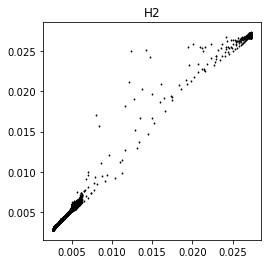

In [7]:
acc_plt('H2')

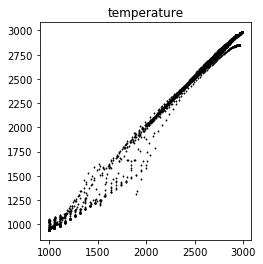

In [8]:
acc_plt('temperature')

![haha](https://raw.githubusercontent.com/uqyge/cantera/master/img/imperial.png)